In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import numpy as np
import torch
from typing import Optional
from scipy.optimize import linear_sum_assignment


def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
    """
    Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
    determine reassignments.
    :param y_true: list of true cluster numbers, an integer array 0-indexed
    :param y_predicted: list  of predicted cluster numbers, an integer array 0-indexed
    :param cluster_number: number of clusters, if None then calculated from input
    :return: reassignment dictionary, clustering accuracy
    """
    if cluster_number is None:
        cluster_number = (
            max(y_predicted.max(), y_true.max()) + 1
        )  # assume labels are 0-indexed
    count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
    for i in range(y_predicted.size):
        count_matrix[y_predicted[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(count_matrix.max() - count_matrix)
    reassignment = dict(zip(row_ind, col_ind))
    accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
    return reassignment, accuracy

In [3]:
def lp_distance(X, Y, p=1):
    """
    Computes row wise minkowski distances between matrices X and Y
    """
    return torch.sum(torch.abs(X-Y)**p, dim=1)**(1/p)

In [4]:
from transformers import PreTrainedTokenizer
from typing import *

def mask_tokens(inputs: torch.Tensor, tokenizer) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original.
    """

    if tokenizer.mask_token is None:
        raise ValueError(
            "This tokenizer does not have a mask token which is necessary for masked language modeling. Remove the --mlm flag if you want to use this tokenizer."
        )

    labels = inputs.clone()
    # We sample a few tokens in each sequence for masked-LM training (with probability args.mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, 0.15)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    if tokenizer._pad_token is not None:
        padding_mask = labels.eq(tokenizer.pad_token_id)
        probability_matrix.masked_fill_(padding_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [5]:
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, texts, labels):
        
        self.texts = texts
        self.labels = labels


        self.labels = torch.tensor(self.labels, dtype=torch.float)
        
    def __getitem__(self, index):
        return self.texts[index], self.labels[index]

    
    def __len__(self):
        return len(self.texts)

In [6]:
# 20 newsgroups
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(
    categories=['comp.graphics', 'talk.religion.misc', 'rec.autos', 'misc.forsale'],
    remove=('headers', 'footers', 'quotes'),
    shuffle=True,
    random_state=42
)
texts, labels = data.data, data.target

<BarContainer object of 4 artists>

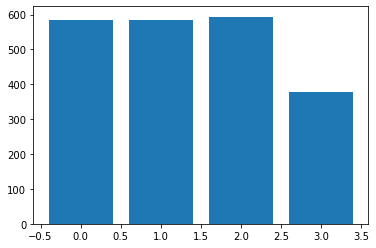

In [7]:
plt.bar(*np.unique(labels, return_counts=True))

In [8]:
#imdb_reviews
#import tensorflow_datasets as tfds
#from itertools import chain
#
#train_ds = tfds.load('imdb_reviews', split='train', shuffle_files=True)
#test_ds = tfds.load('imdb_reviews', split='test', shuffle_files=True)
#
#texts, labels = [], []
#
#for ds in (train_ds, test_ds):
#    for example in tfds.as_numpy(ds):
#        text, label = example['text'], example['label']
#        texts.append(str(text))
#        labels.append(label)
#
#labels = np.array(labels)

In [9]:
from sklearn.model_selection import train_test_split

texts, _, labels, _ = train_test_split(texts, labels, test_size=0.9, random_state=42)

In [10]:
data = TextDataset(texts, labels)
data_loader = DataLoader(dataset=data, batch_size=8, shuffle=False)

In [11]:
from transformers import DistilBertTokenizer, DistilBertForMaskedLM
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', return_dict=True)
lm_model = DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased', return_dict=True)
lm_model.to('cuda')

DistilBertForMaskedLM(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [12]:
from tqdm import tqdm
embeddings = []
for index, text in tqdm(enumerate(texts)):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    inputs = inputs.to('cuda')
    outputs = lm_model.base_model(**inputs)
    cls_embedding = outputs.last_hidden_state[:,0,:].flatten().cpu().detach().numpy() # 
    embeddings.append(cls_embedding)
embeddings = np.array(embeddings)

214it [00:01, 108.16it/s]


In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=np.unique(labels).shape[0], n_init=20)

kmeans_cluster = kmeans.fit_predict(embeddings)
kmean_centroids = torch.from_numpy(kmeans.cluster_centers_)
kmean_centroids = kmean_centroids.to('cuda')

In [14]:
from umap import UMAP

umap = UMAP(n_components=2)
embeddings_plot = umap.fit_transform(embeddings)

/home/keller/.conda/envs/cuda/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10006. The TBB threading layer is disabled.
  warnings.warn(problem)


In [15]:
import plotly.express as px
fig = px.scatter(x=embeddings_plot[:, 0], y=embeddings_plot[:, 1], color=[f'{i}' for i in kmeans_cluster])
fig.show()

In [16]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score

print(cluster_accuracy(labels, kmeans_cluster)[1])
print(normalized_mutual_info_score(labels, kmeans_cluster))
print(adjusted_rand_score(labels, kmeans_cluster))
print(silhouette_score(embeddings, kmeans_cluster, metric="cosine"))

0.5887850467289719
0.3915715445834609
0.3631688808018354
0.20187913


In [17]:
import random
initial_centroids = np.array([embeddings[i] for i in (random.randint(0, embeddings.shape[0]-1) for _ in range(np.unique(labels).shape[0]))])
initial_centroids = torch.from_numpy(initial_centroids).to('cuda')
initial_centroids

tensor([[ 0.0102, -0.0500,  0.0992,  ...,  0.0560,  0.2704,  0.4897],
        [-0.2425, -0.1773,  0.1183,  ...,  0.1950,  0.3794,  0.1393],
        [-0.2816, -0.0659, -0.0719,  ..., -0.0617,  0.1400,  0.5703],
        [ 0.1527,  0.1480, -0.1585,  ...,  0.0212,  0.6128,  0.3740]],
       device='cuda:0')

Epoch 0 (Alpha -0.0) | Batch: 26 | Combined Loss: 5.367351494307771 | Clustering Loss: 96.72128526669559 | LM Loss 2.949319362640381 | Accuracy 0.6666666666666666: : 27it [00:08,  3.31it/s]


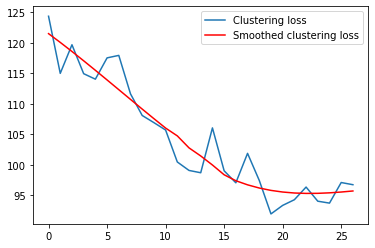

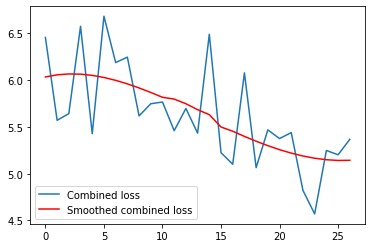

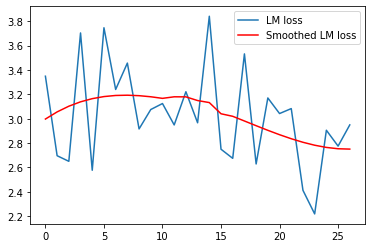

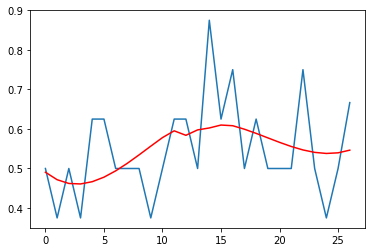

Epoch 1 (Alpha -0.05263157894736842) | Batch: 26 | Combined Loss: 4.789717986956579 | Clustering Loss: 82.09011375011374 | LM Loss 2.7374651432037354 | Accuracy 0.5: : 27it [00:08,  3.31it/s]  


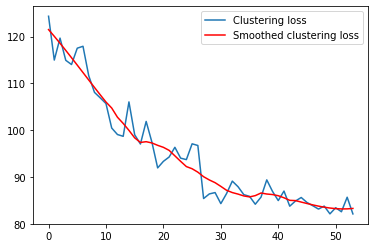

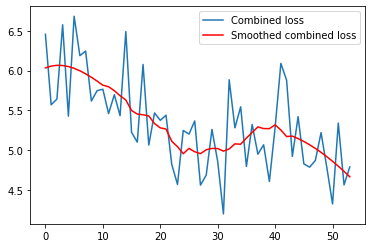

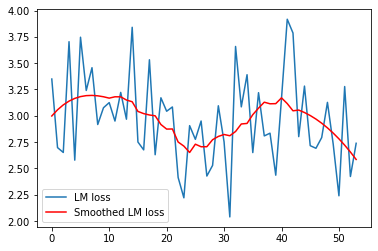

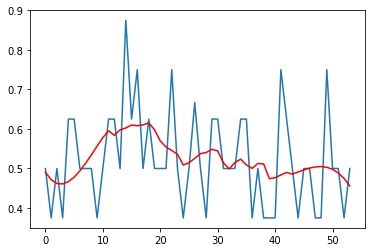

Epoch 2 (Alpha -0.10526315789473684) | Batch: 26 | Combined Loss: 4.493507232473593 | Clustering Loss: 76.3739429396908 | LM Loss 2.5841586589813232 | Accuracy 0.8333333333333334: : 27it [00:08,  3.29it/s]


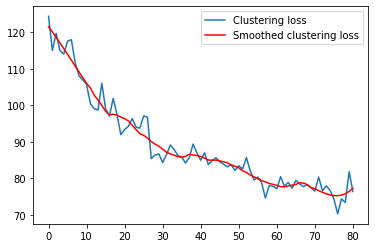

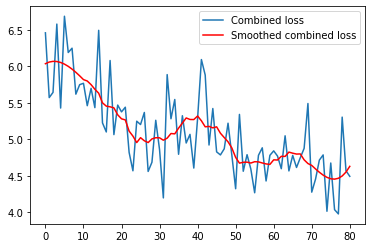

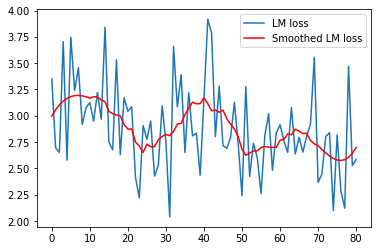

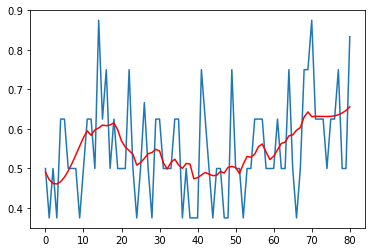

Epoch 3 (Alpha -0.15789473684210525) | Batch: 26 | Combined Loss: 4.20249054199971 | Clustering Loss: 65.87988748809389 | LM Loss 2.5554933547973633 | Accuracy 0.8333333333333334: : 27it [00:08,  3.29it/s]


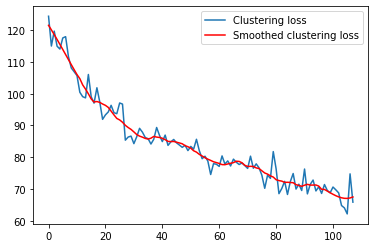

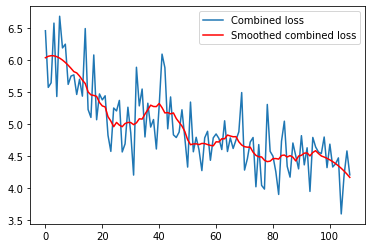

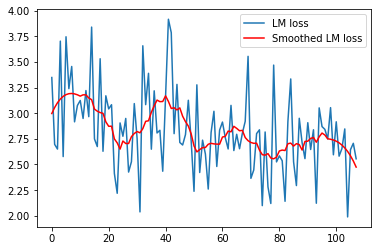

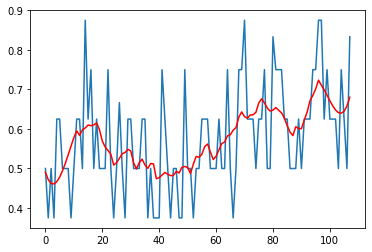

Epoch 4 (Alpha -0.21052631578947367) | Batch: 26 | Combined Loss: 3.481400940025569 | Clustering Loss: 58.733729251413386 | LM Loss 2.0130577087402344 | Accuracy 0.8333333333333334: : 27it [00:08,  3.26it/s]


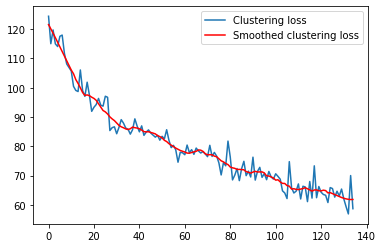

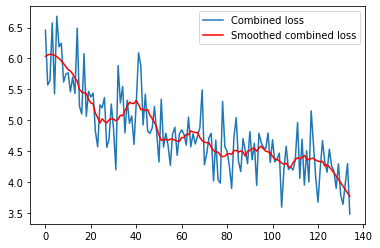

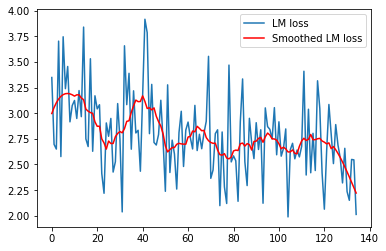

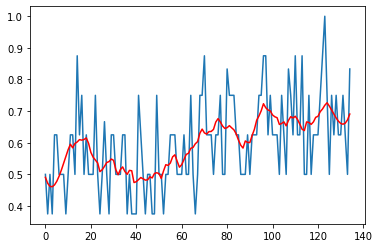

Epoch 5 (Alpha -0.2631578947368421) | Batch: 26 | Combined Loss: 3.698713187986975 | Clustering Loss: 55.748057548775876 | LM Loss 2.305011749267578 | Accuracy 0.8333333333333334: : 27it [00:08,  3.24it/s]


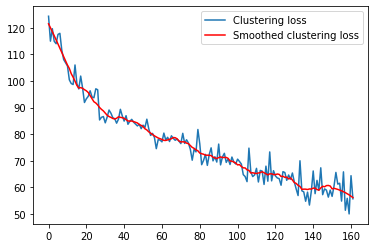

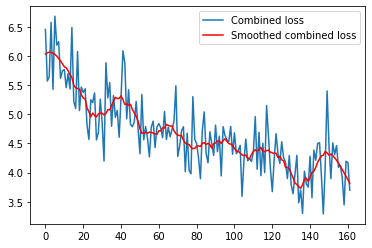

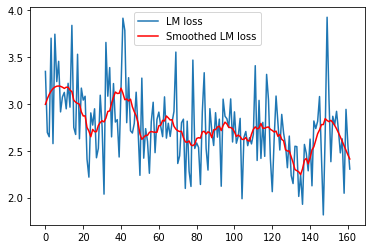

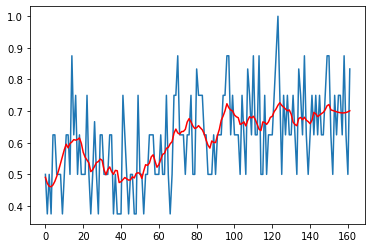

Epoch 6 (Alpha -0.3157894736842105) | Batch: 26 | Combined Loss: 3.7748008670960314 | Clustering Loss: 52.38539100708344 | LM Loss 2.4651660919189453 | Accuracy 0.8333333333333334: : 27it [00:08,  3.22it/s]


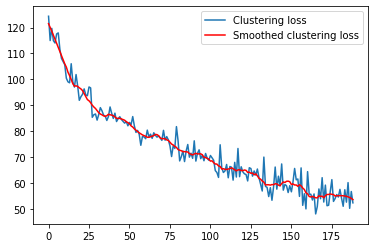

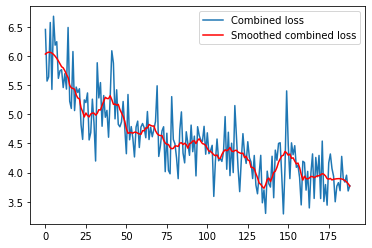

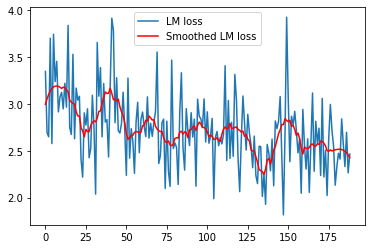

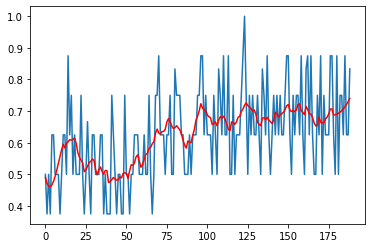

Epoch 7 (Alpha -0.3684210526315789) | Batch: 26 | Combined Loss: 3.6501359376270868 | Clustering Loss: 46.723773610430136 | LM Loss 2.482041597366333 | Accuracy 0.8333333333333334: : 27it [00:08,  3.22it/s]


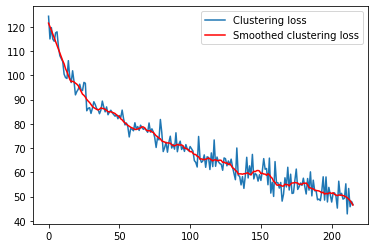

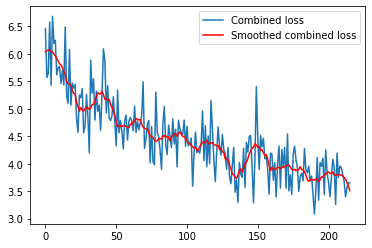

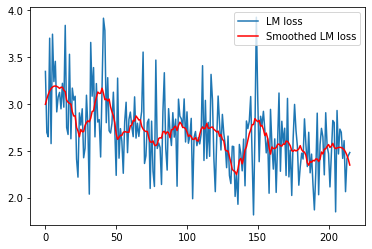

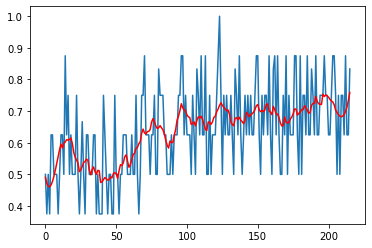

Epoch 8 (Alpha -0.42105263157894735) | Batch: 26 | Combined Loss: 3.2544164651256704 | Clustering Loss: 45.448379491257285 | LM Loss 2.1182069778442383 | Accuracy 0.8333333333333334: : 27it [00:08,  3.19it/s]


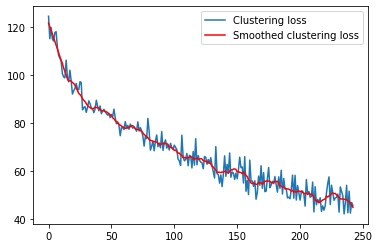

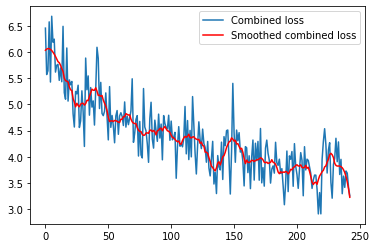

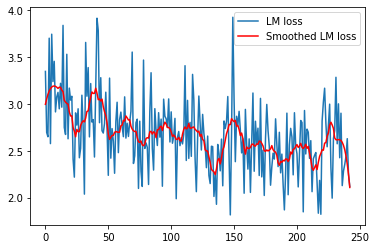

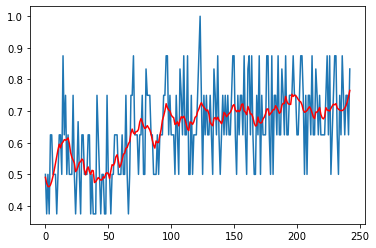

Epoch 9 (Alpha -0.47368421052631576) | Batch: 26 | Combined Loss: 3.4874078927916763 | Clustering Loss: 44.00586008422563 | LM Loss 2.387261390686035 | Accuracy 0.8333333333333334: : 27it [00:08,  3.19it/s]


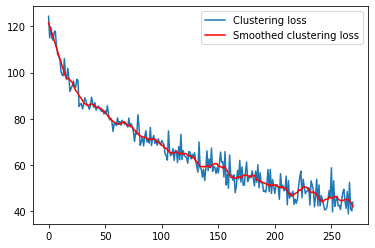

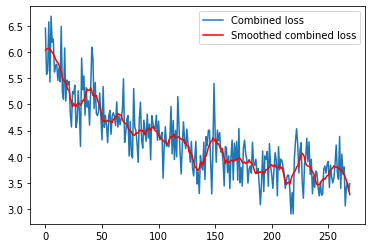

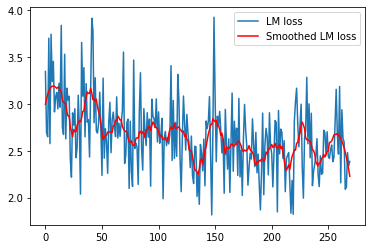

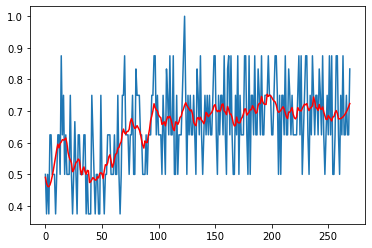

Epoch 10 (Alpha -0.5263157894736842) | Batch: 26 | Combined Loss: 3.253543159984898 | Clustering Loss: 41.070233250592196 | LM Loss 2.2267873287200928 | Accuracy 0.8333333333333334: : 27it [00:08,  3.14it/s]


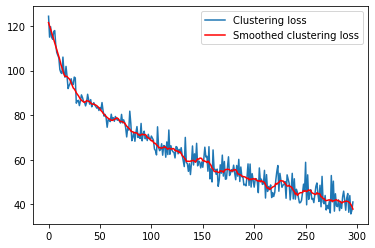

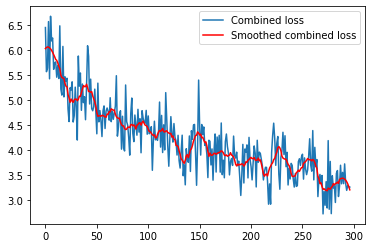

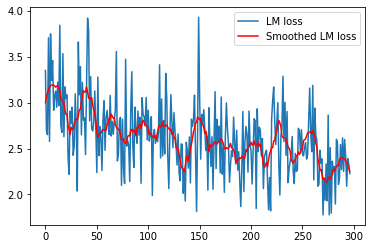

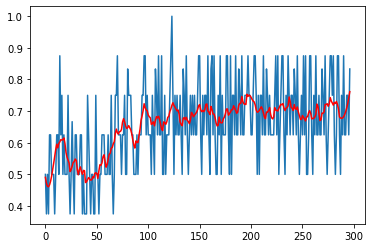

Epoch 11 (Alpha -0.5789473684210527) | Batch: 26 | Combined Loss: 3.3396702715312507 | Clustering Loss: 42.11450937809574 | LM Loss 2.2868075370788574 | Accuracy 0.8333333333333334: : 27it [00:08,  3.12it/s]


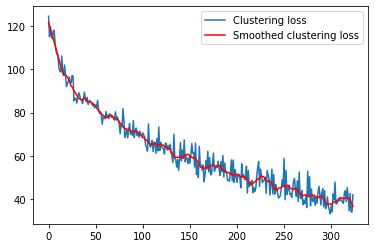

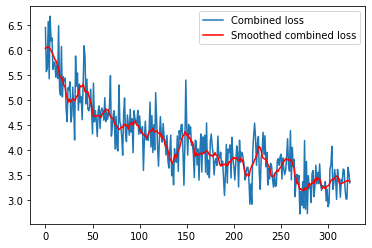

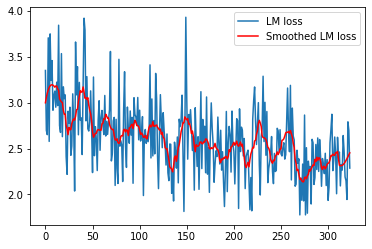

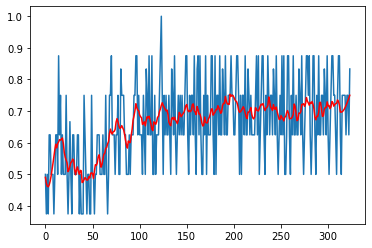

Epoch 12 (Alpha -0.631578947368421) | Batch: 26 | Combined Loss: 3.0285312304470935 | Clustering Loss: 38.77595571507612 | LM Loss 2.0591323375701904 | Accuracy 0.8333333333333334: : 27it [00:08,  3.12it/s]


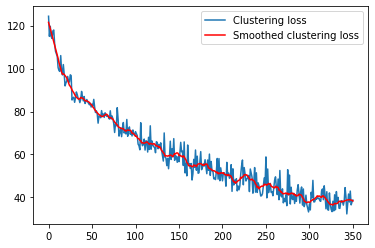

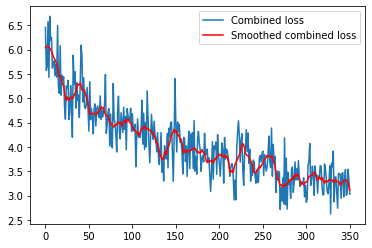

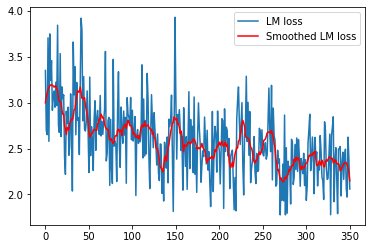

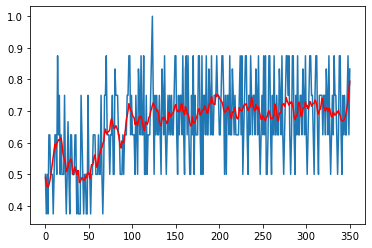

Epoch 13 (Alpha -0.6842105263157894) | Batch: 26 | Combined Loss: 3.1663449837421798 | Clustering Loss: 40.82992010774383 | LM Loss 2.145596981048584 | Accuracy 0.8333333333333334: : 27it [00:08,  3.10it/s]


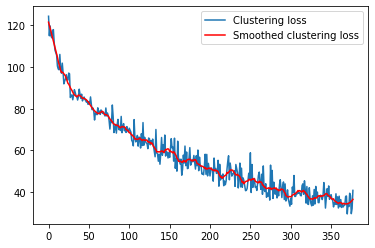

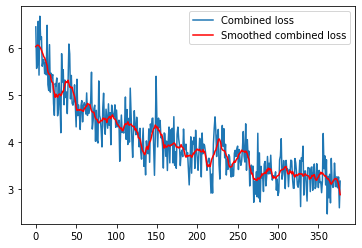

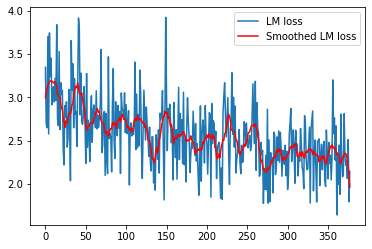

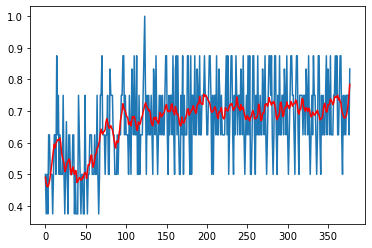

Epoch 14 (Alpha -0.7368421052631579) | Batch: 26 | Combined Loss: 2.9944101065389015 | Clustering Loss: 37.86966598030606 | LM Loss 2.04766845703125 | Accuracy 0.8333333333333334: : 27it [00:08,  3.13it/s]


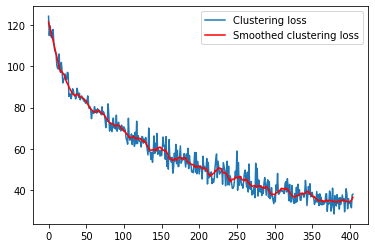

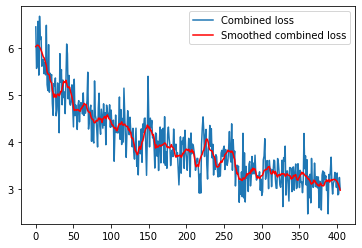

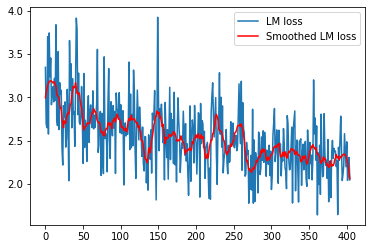

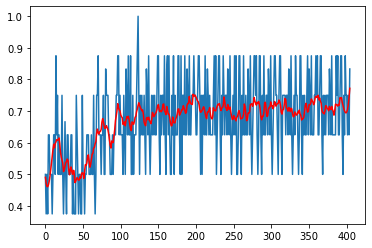

Epoch 15 (Alpha -0.7894736842105263) | Batch: 26 | Combined Loss: 3.1562746438758214 | Clustering Loss: 33.5616337195104 | LM Loss 2.3172338008880615 | Accuracy 0.8333333333333334: : 27it [00:08,  3.19it/s]


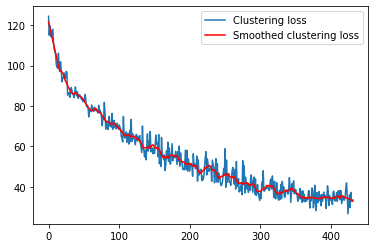

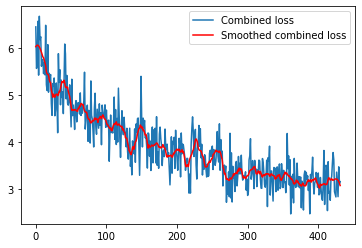

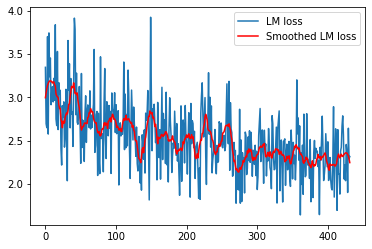

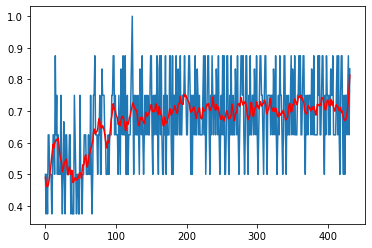

Epoch 16 (Alpha -0.8421052631578947) | Batch: 26 | Combined Loss: 2.57222409038707 | Clustering Loss: 35.12002268988466 | LM Loss 1.6942235231399536 | Accuracy 0.8333333333333334: : 27it [00:08,  3.14it/s]


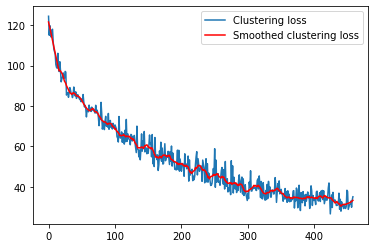

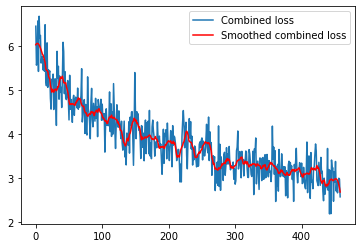

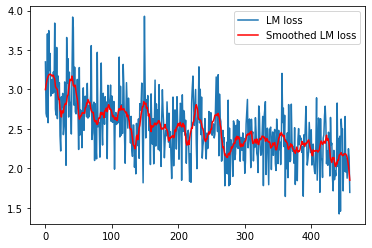

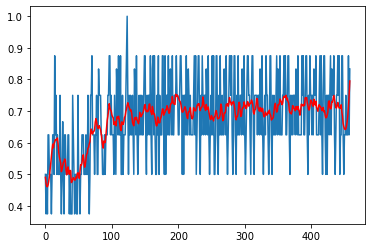

Epoch 17 (Alpha -0.894736842105263) | Batch: 26 | Combined Loss: 2.7074326095054104 | Clustering Loss: 30.108241308011824 | LM Loss 1.9547265768051147 | Accuracy 0.8333333333333334: : 27it [00:08,  3.14it/s]


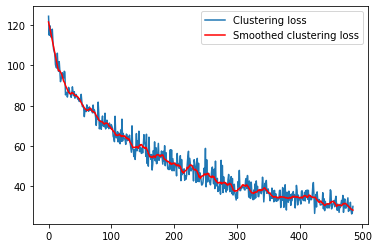

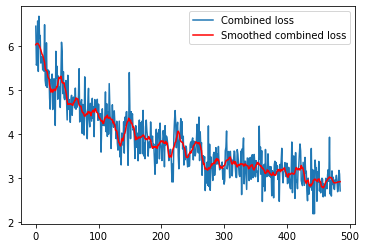

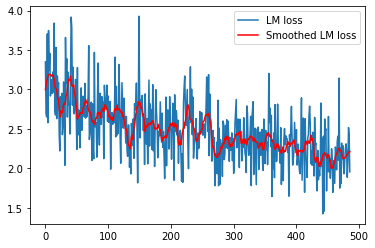

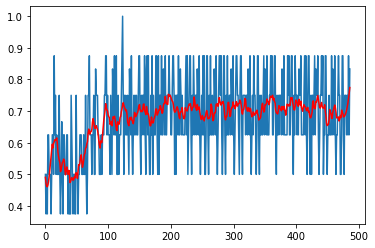

Epoch 18 (Alpha -0.9473684210526315) | Batch: 26 | Combined Loss: 2.94626746149672 | Clustering Loss: 33.29103850198306 | LM Loss 2.1139914989471436 | Accuracy 0.8333333333333334: : 27it [00:08,  3.12it/s]


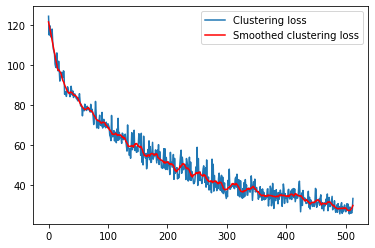

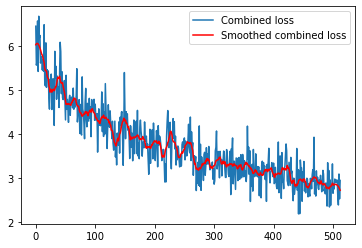

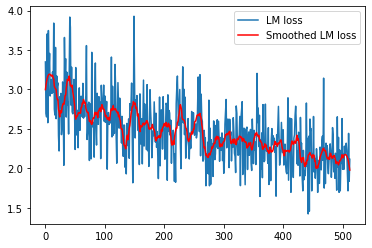

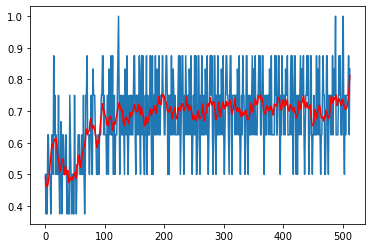

Epoch 19 (Alpha -1.0) | Batch: 26 | Combined Loss: 3.060244472856608 | Clustering Loss: 29.16402467232097 | LM Loss 2.331143856048584 | Accuracy 0.8333333333333334: : 27it [00:08,  3.18it/s]


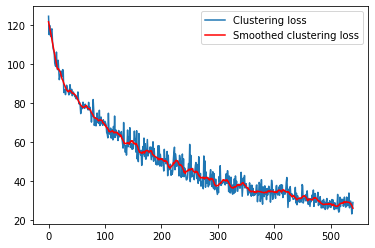

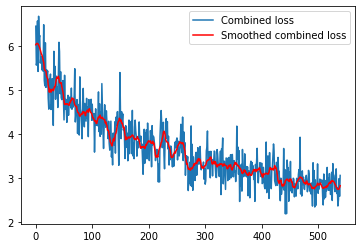

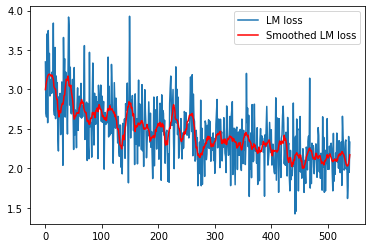

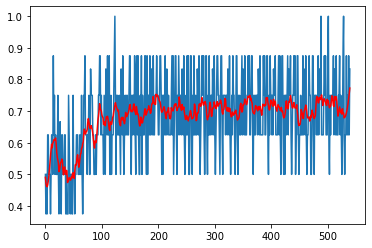

In [18]:
from scipy.signal import savgol_filter

centroids = initial_centroids.clone().to('cuda').requires_grad_(True)
#centroids = torch.Tensor(4, 768).uniform_(-10, 10).to(torch.float64).to('cuda').requires_grad_(True)
#centroids = kmean_centroids.clone().to('cuda').requires_grad_(True)  # go this way (cluster hardening)

#opt = torch.optim.SGD(params=[centroids] + list(lm_model.parameters()), lr=0.001)
opt = torch.optim.AdamW(params=[centroids] + list(lm_model.parameters()), lr = 2e-5, eps = 1e-8 )

lm_model.train()

comb_losses = []
clustering_losses = []
lm_losses = []
c_hist = []
emb_hist = []
acc = []

n_epochs = 20
annealing_alpha = np.linspace(0, 1, n_epochs)
#annealing_alpha = [0.1] * n_epochs
for epoch, alpha in zip(range(n_epochs), annealing_alpha):
    
    predicted_labels = []
    true_labels = []
    embs = []
    t = [] # improve this asap!

    c_hist.append(centroids.clone().detach().cpu().numpy())
    pbar = tqdm(enumerate(data_loader))
    for batch, batch_data in pbar:
        # lm part 
        texts, batch_labels = batch_data
        inputs = tokenizer(
                    texts,
                    return_tensors='pt',
                    padding=True,
                    truncation=True)
        t.extend(texts)
        #inputs = inputs.to('cuda') # due to lm loss
        
        true_labels.extend(batch_labels)
        
        
        # clustering part
        input_ids = inputs['input_ids'].clone()
        input_ids, labels = mask_tokens(input_ids, tokenizer)
        inputs['input_ids'] = input_ids

        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        outputs = lm_model(labels=labels, **inputs)
        lm_loss = outputs.loss
        
        
        texts, batch_labels = batch_data
        inputs = tokenizer(
                    texts,
                    return_tensors='pt',
                    padding=True,
                    truncation=True)
        inputs.to('cuda')
        
        # 0. obtain embeddings for each input
        input_embeddings = lm_model.base_model(**inputs).last_hidden_state[:,0,:]
        input_embeddings = input_embeddings.to(torch.float64)
        
        embs.append(input_embeddings.clone().cpu().detach().numpy())

        distances = torch.stack([lp_distance(embedding.unsqueeze(0), centroids) for embedding in input_embeddings])
        #nearest_centroids = torch.argmin(distances, dim=1).cpu().clone().detach()
        nearest_centroids = torch.argmin(distances.cpu().clone().detach(), dim=1)
        distances = torch.transpose(distances, 0, 1)    

        # => shape (n_centroids, n_samples)
        # 2. compute the softmax for each centroid of each distance to each centroid per input sample
        # find min distances for each centroid
        min_distances = torch.min(distances, dim=1).values
        exponentials = torch.exp(- alpha * (distances - min_distances.unsqueeze(1)))
        softmax = exponentials / torch.sum(exponentials, dim=1).unsqueeze(1)

        # 3. weight the distanace between each sample and each centroid
        weighted_distances = distances * softmax


        # 4. sum over centroids to obtain loss
        opt.zero_grad()
        
        clustering_loss = weighted_distances.sum(dim=1).mean()
        comb_loss = (lm_loss * 1) + (0.025 * clustering_loss) # 2.0 | 0.005
        comb_loss.backward()

        opt.step()

        accuracy = cluster_accuracy(batch_labels.numpy().astype('int'), nearest_centroids.numpy().astype('int'))[1]
        acc.append(accuracy)
        predicted_labels.extend(nearest_centroids.numpy())
        clustering_losses.append(clustering_loss.item())
        lm_losses.append(lm_loss.item())
        comb_losses.append(comb_loss.item())
        
        pbar.set_description(f"Epoch {epoch} (Alpha -{alpha}) | Batch: {batch} | Combined Loss: {comb_loss.item()} | Clustering Loss: {clustering_loss.item()} | LM Loss {lm_loss.item()} | Accuracy {accuracy}")
        
        #print(centroids)
    emb_hist.append(embs)
    plt.plot(clustering_losses, label="Clustering loss")
    plt.plot(savgol_filter(clustering_losses, 21, 3), color='red', label="Smoothed clustering loss")
    plt.legend()
    plt.show()
    plt.plot(comb_losses, label="Combined loss")
    plt.plot(savgol_filter(comb_losses, 21, 3), color='red', label="Smoothed combined loss")
    plt.legend()
    plt.show()
    plt.plot(lm_losses, label="LM loss")
    plt.plot(savgol_filter(lm_losses, 21, 3), color='red', label="Smoothed LM loss")
    plt.legend()
    plt.show()
    plt.plot(acc, label="Batch Accuracy")
    plt.plot(savgol_filter(acc, 21, 3), color='red', label="Smoothed Batch Accuracy")
    plt.show()
    
    # eval part

In [19]:
np_centroids = centroids.cpu().detach().numpy()
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels).astype('int')
true_labels.shape, predicted_labels.shape

embs = np.vstack(embs)

In [20]:
print(cluster_accuracy(true_labels, predicted_labels))
print(normalized_mutual_info_score(true_labels, predicted_labels))
print(adjusted_rand_score(true_labels, predicted_labels))

({0: 2, 1: 1, 2: 0, 3: 3}, 0.6401869158878505)
0.37173327539448764
0.32426829162284093


In [21]:
np.unique(predicted_labels, return_counts=True)

(array([0, 1, 2, 3]), array([54, 45, 61, 54]))

In [22]:
np.unique(true_labels, return_counts=True)

(array([0, 1, 2, 3]), array([66, 50, 59, 39]))

In [23]:
np.unique(kmeans_cluster, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([76, 61, 10, 67]))

In [24]:
from umap import UMAP
from sklearn.decomposition import PCA
reducer = UMAP(n_components=2, n_neighbors=20)
#reducer = PCA(n_components=2)
Xo = np.vstack([embs, np_centroids])
Xro = reducer.fit_transform(Xo)
labels_co = np.concatenate([predicted_labels, [f"Centroid {i}" for i in range(centroids.shape[0])]])
label_kmeans = np.concatenate([kmeans_cluster, [f"Centroid {i}" for i in range(centroids.shape[0])]])

In [25]:
t = [" ".join(i.split()) for i in t]

In [26]:
import plotly.express as px
fig = px.scatter(x=Xro[:, 0], y=Xro[:, 1], color=[f'{i}' for i in labels_co], hover_name=t+["centroid"]*centroids.shape[0])
fig.show()

In [27]:
import plotly.express as px
fig = px.scatter(x=Xro[:, 0], y=Xro[:, 1], color=[f'{i}' for i in label_kmeans], hover_name=t+["centroid"]*centroids.shape[0])
fig.show()

In [28]:
(np.vstack(emb_hist[0]) == np.vstack(emb_hist[-1])).all()

False

In [29]:
np.vstack(emb_hist[0]) == np.vstack(emb_hist[-1])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [30]:
print(* np.array(t)[np.array(predicted_labels) == 0], sep="\n"+"#"*100+"\n\n")

A "fuel injector cleaning" at the dealer is probably little more than them opening your gas tank, dumping in a bottle of fuel injector cleaner, and sending you on your merry way $59 poorer. Go to KMart and buy the cleaner yourself for $1.29. Just because you dealer sez you need it, don't mean it's necessarily so. Be suspicious.
####################################################################################################

do not pay $40 for floppy drives.. they are about $40 new. also, you do not need documentation for floppies. installation for these things are idiot proof. just some advice..
####################################################################################################

In regards to fractal commpression, I have seen 2 fractal compressed "movies". They were both fairly impressive. The first one was a 64 gray scale "movie" of Casablanca, it was 1.3MB and had 11 minutes of 13 fps video. It was a little grainy but not bad at all. The second one I saw was only

In [31]:
np.unique(predicted_labels)

array([0, 1, 2, 3])

In [32]:
np.unique(true_labels)

array([0, 1, 2, 3])

In [33]:
np.vstack(emb_hist[-1])

array([[-0.27698854, -0.05685056, -0.07183562, ..., -0.05849707,
         0.16001724,  0.57820243],
       [-0.27026701, -0.04902336, -0.04394388, ...,  0.05498244,
         0.21743317,  0.52771866],
       [-0.26874822, -0.14219062,  0.13143305, ...,  0.20641516,
         0.38316488,  0.1103496 ],
       ...,
       [ 0.0260512 ,  0.01281363, -0.01042941, ...,  0.04270036,
         0.35969058,  0.5080148 ],
       [-0.2671603 , -0.15459061,  0.06203818, ...,  0.17891555,
         0.2904619 ,  0.17421864],
       [-0.33209068, -0.04853648, -0.06228845, ..., -0.01738521,
         0.14794263,  0.55302477]])

In [34]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=np.unique(true_labels).shape[0], n_init=20)

end_embeddings_kmeans_cluster = kmeans.fit_predict(np.vstack(emb_hist[4]))

In [35]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

print(cluster_accuracy(true_labels, end_embeddings_kmeans_cluster)[1])
print(normalized_mutual_info_score(true_labels, end_embeddings_kmeans_cluster))
print(adjusted_rand_score(true_labels, end_embeddings_kmeans_cluster))

0.5514018691588785
0.2996132984776843
0.25713808948905187


In [36]:
from sklearn.metrics import silhouette_score
silhouette_score(np.vstack(emb_hist[-1]), end_embeddings_kmeans_cluster, metric="cosine")

0.13774902722925525

In [37]:
from sklearn.metrics import silhouette_score
silhouette_score(np.vstack(emb_hist[-1]), predicted_labels, metric="cosine")

0.3594226986999278